In [54]:
import numpy as np
from numpy.linalg import inv
from tkinter import *
import matplotlib.pyplot as plt


In [55]:
class KalmanFilter:
    """
    Simple Kalman filter
    """

    def __init__(self, X, F, Q, Z, H, R, P):
        """
        Initialise the filter
        Args:
            X: State estimate
            P: Estimate covariance
            F: State transition model
            Q: Process noise covariance
            Z: Measurement of the state X
            H: Observation model
            R: Observation noise covariance
        """
        self.X = X
        self.P = P
        self.F = F
        self.Q = Q
        self.Z = Z
        self.H = H
        self.R = R

    def predict(self):
        """
        Predict the future state
        Args:
            self.X: State estimate
            self.P: Estimate covariance

        Returns:
            updated self.X
        """
        # Project the state ahead
        self.X = self.F @ self.X
        self.P = self.F @ self.P @ self.F.T + self.Q

        return self.X

    def update(self, Z):
        """
        Update the Kalman Filter from a measurement
        Args:
            self.X: State estimate
            self.P: Estimate covariance
            Z: State measurement
        Returns:
            updated X
        """
        K = self.P @ self.H.T @ inv(self.H @ self.P @ self.H.T + self.R)
        self.X += K @ (Z - self.H @ self.X)
        self.P = self.P - K @ self.H @ self.P

        return self.X

    def weights(self, Q, R):
        self.Q = Q
        self.R = R


In [56]:
class Points:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

    

In [59]:
modelTrust = 0.0001
noiseLvl = 3

stateMatrix = np.zeros((4, 1))  # [x, y, delta_x, delta_y]
estimateCovariance = np.eye(stateMatrix.shape[0])
transitionMatrix = np.array(
    [[1, 0, 1, 0],
     [0, 1, 0, 1], 
     [0, 0, 1, 0], 
     [0, 0, 0, 1]])
processNoiseCov = np.array([
    [1, 0, 0, 0], 
    [0, 1, 0, 0], 
    [0, 0, 1, 0], 
    [0, 0, 0, 1]]) * modelTrust
measurementStateMatrix = np.zeros((2, 1))
observationMatrix = np.array([
    [1, 0, 0, 0], 
    [0, 1, 0, 0]])
measurementNoiseCov = np.array([
    [1, 0], 
    [0, 1]]) * noiseLvl
kalman = KalmanFilter(X=stateMatrix,
                      P=estimateCovariance,
                      F=transitionMatrix,
                      Q=processNoiseCov,
                      Z=measurementStateMatrix,
                      H=observationMatrix,
                      R=measurementNoiseCov)


0.0001


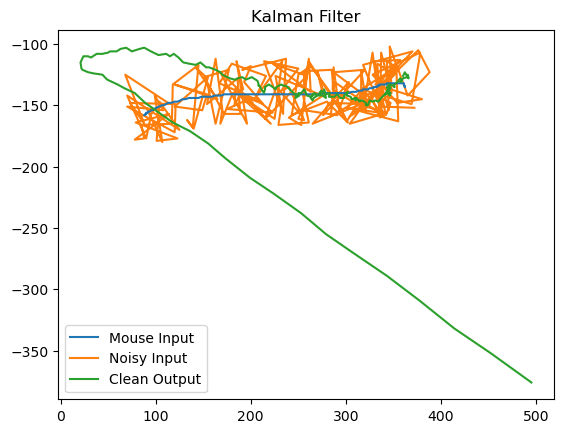

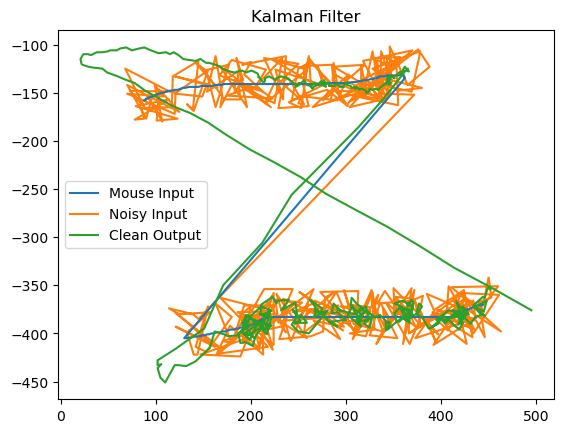

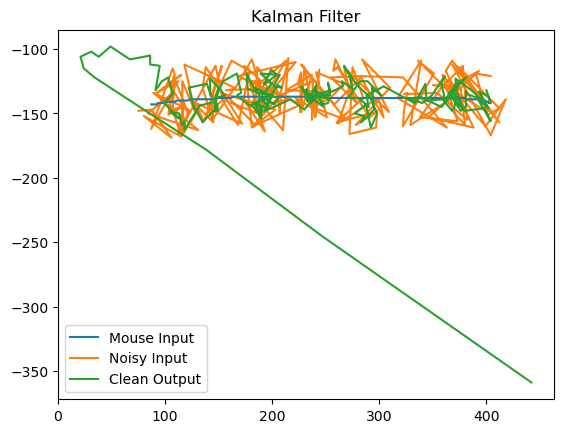

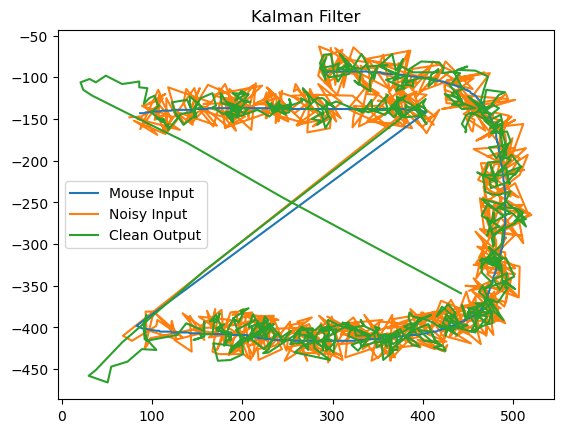

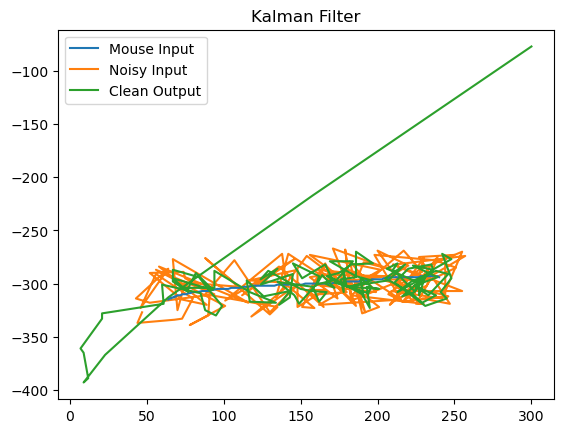

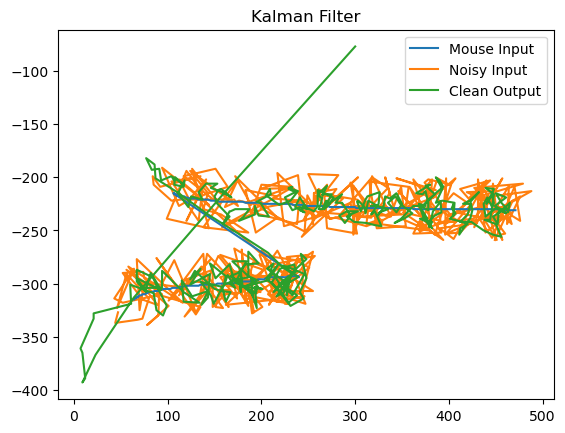

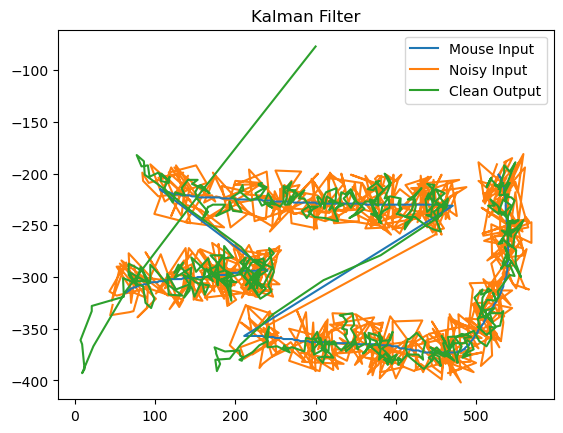

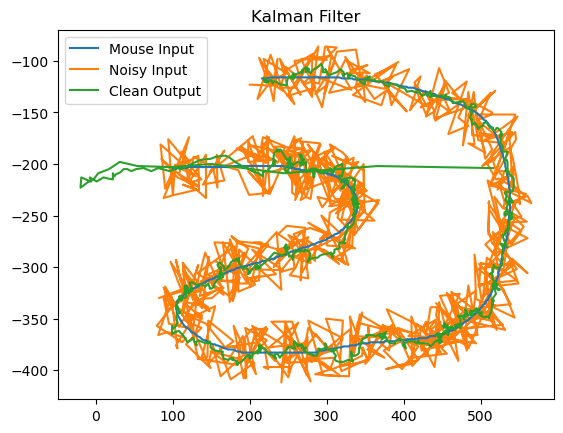

In [64]:
app = Tk()
app.title("Mouse Kalman Filter")


canvas = Canvas(app, width=640, height=480, bg='black')
canvas.pack(anchor='nw', fill='both', expand=1)
realcords = []
noiseCords = []
filterCords = []


def get_x_and_y(event):
    global lasx, lasy
    global laspx, laspy
    global lasnx, lasny

    lasx, lasy = event.x, event.y
    laspx, laspy = event.x + \
        np.random.randint(-30, 30), event.y+np.random.randint(-30, 30)
    lasnx, lasny = event.x + \
        np.random.randint(-30, 30), event.y+np.random.randint(-30, 30)


def draw(event):
    global lasx, lasy
    global laspx, laspy
    global lasnx, lasny
    global predict, measure

    canvas.create_line((lasx, lasy, event.x, event.y), fill='red', width=2)
    realcords.append(Points(event.x, event.y))
    # noise points
    xnoise = event.x+np.random.randint(-30, 30)
    ynoise = event.y+np.random.randint(-30, 30)
    canvas.create_line(lasnx, lasny, xnoise+1, ynoise+1, fill='green')
    noiseCords.append(Points(xnoise, ynoise))
    measure = np.array([[xnoise], [ynoise]])

    # plot prediction
    predict = kalman.predict()
    xpred = predict[0, 0].round()
    ypred = predict[1, 0].round()
    canvas.create_line(laspx, laspy, xpred, ypred, fill='white')
    filterCords.append(Points(xpred, ypred))
    kalman.update(measure)

    laspx, laspy = xpred, ypred
    lasnx, lasny = xnoise, ynoise
    lasx, lasy = event.x, event.y


def release(event):

    real = np.array([list([i.x, i.y])for i in realcords])
    noisy = np.array([list([i.x, i.y])for i in noiseCords])
    clean = np.array([list([i.x, i.y])for i in filterCords])
    plt.plot(real[:, 0], -1*real[:, 1], label='Mouse Input', zorder=1)
    plt.plot(noisy[:, 0], -1*noisy[:, 1], label='Noisy Input', zorder=0)
    plt.plot(clean[:, 0], -1*clean[:, 1], label='Clean Output', zorder=1)
    plt.title("Kalman Filter")
    plt.legend()
    plt.show()


def clear(event):
    canvas.delete('all')
    realcords.clear()
    noiseCords.clear()
    filterCords.clear()
    infoText()


def infoText():
    canvas.create_text(50, 20, text="__ Real", fill="red", font=('Helvetica'))
    canvas.create_text(120, 20, text="_ _ Noisy",
                       fill="green", font=('Helvetica'))
    canvas.create_text(200, 20, text="__ Clean",
                       fill="white", font=('Helvetica'))
    canvas.create_text(480, 460, text="Left click and drag. Right click to clean",
                       fill="white", font=('Helvetica'))


def updateVals():
    modelTrust = w.get()
    noiseLvl = w1.get()
    processNoiseCov = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]]) * modelTrust
    measurementNoiseCov = np.array([
        [1, 0],
        [0, 1]]) * noiseLvl
    kalman.weights(processNoiseCov, measurementNoiseCov)


def sliders():
    global w, w1
    l1 = Label(app, text="Model Trust")
    l1.pack()
    w = Scale(app, from_=0.00001, to=.1, orient=HORIZONTAL,
              resolution=.0001, length=300, variable=modelTrust)
    w.set(.0001)
    w.pack()

    l2 = Label(app, text="Measurements Trust")
    l2.pack()
    w1 = Scale(app, from_=0, to=4, resolution=.0001,
               orient=HORIZONTAL, length=300, variable=noiseLvl)
    w1.set(3)
    w1.pack()

    b1 = Button(app, text="Update Values",
                command=updateVals)
    b1.pack()


sliders()
infoText()


canvas.bind("<Button-1>", get_x_and_y)
canvas.bind("<B1-Motion>", draw)
canvas.bind("<ButtonRelease-1>", release)
canvas.bind("<Button-3>", clear)

app.mainloop()
